In [1]:
import plot
from scipy.special import expit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from copy import deepcopy
import shap
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline

This is based on scikit-learn example [Logistic function](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic.html#sphx-glr-auto-examples-linear-model-plot-logistic-py)

In [2]:
try:
    with open('dataset.pickle', 'rb') as f:
        print('Loaded cached dataset')
        X, X_test, y, feature_names, n_features, n_samples = pickle.load(f)
except FileNotFoundError:
    print('No cached dataset found')

Loaded cached dataset


In [3]:
try:
    with open('classifiers.pickle', 'rb') as f:
        clf_a, clf_b = pickle.load(f)
        print('Loaded cached models')
except FileNotFoundError:
    print('No cached models found')

Loaded cached models


In [4]:
try:
    with open('predictions.pickle', 'rb') as f:
        X_clean, feature_names, n_features, n_samples_clean, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)
        print('Loaded cached predictions')
except FileNotFoundError:
    print('No cached predictions found')

Loaded cached predictions


## Generate Data

In [5]:
n_samples = 1000
n_features = 1
feature_names = ['x1']
np.random.seed(0)
X = np.random.normal(size=n_samples)
y = (X > 0)
X[X > 0] *= 4
X += .3 * np.random.normal(size=n_samples)
X_test = np.linspace(-5, 7, 300)
X = X[:, np.newaxis]
with open('dataset.pickle', 'wb') as f:
    pickle.dump((X, X_test, y, feature_names, n_features, n_samples), f, pickle.HIGHEST_PROTOCOL)

## Train Models

In [6]:
%%time
clf_a = LogisticRegression(C=1e5)
clf_a.fit(X, y)
clf_b = deepcopy(clf_a)
clf_b.intercept_ -= 10
with open('classifiers.pickle', 'wb') as f:
    pickle.dump((clf_a, clf_b), f, pickle.HIGHEST_PROTOCOL)

CPU times: user 7.68 ms, sys: 2.51 ms, total: 10.2 ms
Wall time: 11.1 ms


## Analyze Results

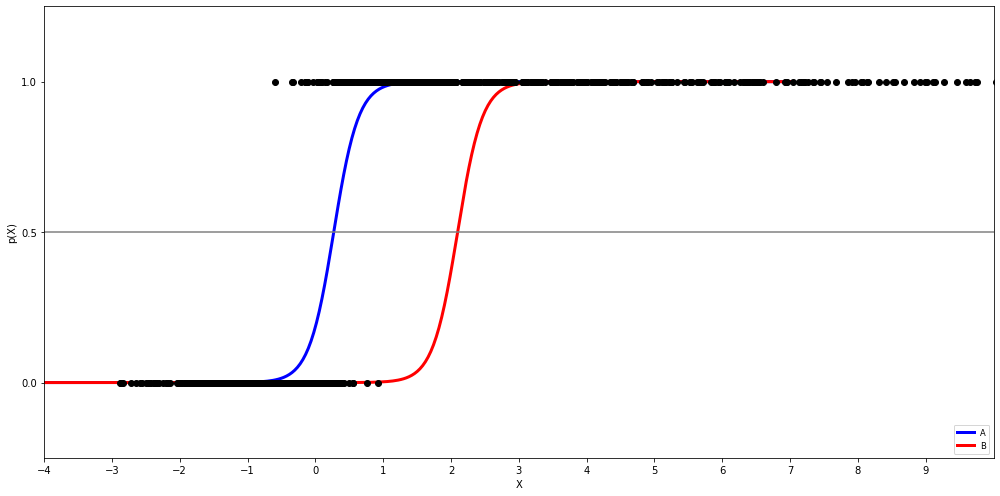

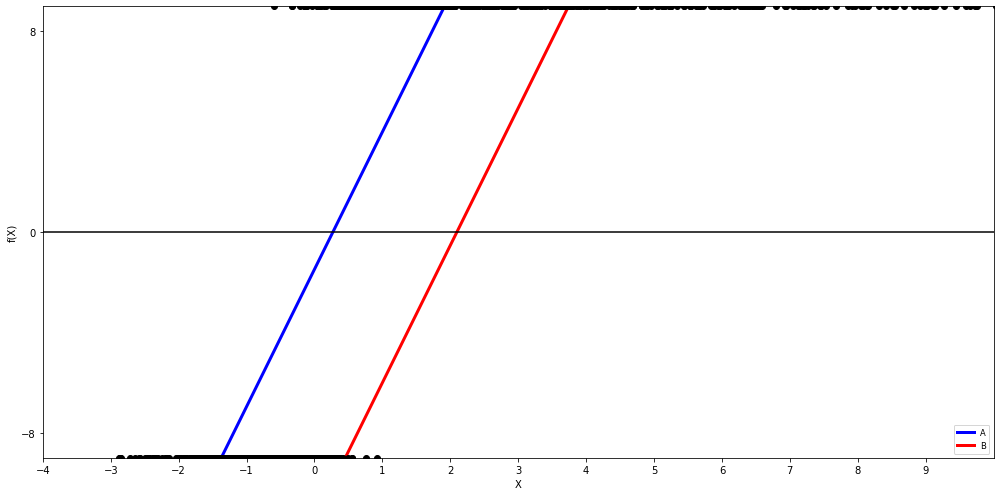

In [7]:
margin_a = (X_test * clf_a.coef_ + clf_a.intercept_).ravel()
margin_b = (X_test * clf_b.coef_ + clf_b.intercept_).ravel()
loss_a = expit(margin_a)
loss_b = expit(margin_b)

plt.figure(1, figsize=(7*2, 7))
plt.clf()
plt.scatter(X.ravel(), y, color='black', zorder=20)
plt.plot(X_test, loss_a, color='blue', linewidth=3)
plt.plot(X_test, loss_b, color='red', linewidth=3)
plt.axhline(.5, color='.5')
plt.ylabel('p(X)')
plt.xlabel('X')
plt.xticks(range(-5, 10))
plt.yticks([0, 0.5, 1])
plt.ylim(-.25, 1.25)
plt.xlim(-4, 10)
plt.legend(('A', 'B'), loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()

plt.figure(1, figsize=(7*2, 7))
plt.clf()
plt.scatter(X.ravel(), np.where(y == 1, 9, -9), color='black', zorder=20)
plt.plot(X_test, margin_a, color='blue', linewidth=3)
plt.plot(X_test, margin_b, color='red', linewidth=3)
plt.axhline(0, color='0')
plt.ylabel('f(X)')
plt.xlabel('X')
plt.xticks(range(-5, 10))
plt.yticks([-8, 0, 8])
plt.ylim(-9, 9)
plt.xlim(-4, 10)
plt.legend(('A', 'B'), loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()

## Visualize Distributions of Predictions

In [8]:
log_proba_a = clf_a.predict_log_proba(X)
log_proba_b = clf_b.predict_log_proba(X)
log_odds_a = log_proba_a[:, 1] - log_proba_a[:, 0]
log_odds_b = log_proba_b[:, 1] - log_proba_b[:, 0]

is_finite = np.isfinite(log_odds_a) & np.isfinite(log_odds_b)
X_clean = X[is_finite]

n_samples_clean = X_clean.shape[0]
indices = np.array(range(n_samples_clean))
pred_a = clf_a.predict(X_clean)
pred_b = clf_b.predict(X_clean)
proba_a = clf_a.predict_proba(X_clean)
proba_b = clf_b.predict_proba(X_clean)
log_proba_a = clf_a.predict_log_proba(X_clean)
log_proba_b = clf_b.predict_log_proba(X_clean)
log_odds_a = log_proba_a[:, 1] - log_proba_a[:, 0]
log_odds_b = log_proba_b[:, 1] - log_proba_b[:, 0]

with open('predictions.pickle', 'wb') as f:
    pickle.dump((X_clean, feature_names, n_features, n_samples_clean, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b), f, pickle.HIGHEST_PROTOCOL)

divide by zero encountered in log
divide by zero encountered in log


Instances with non-finite log-odds predictions:

In [9]:
pd.DataFrame(X[~is_finite]).describe()

,0
count,41.000000
mean,8.454640
std,1.049090
min,7.042070
25%,7.451620
50%,8.309066
75%,9.141235
max,10.930147


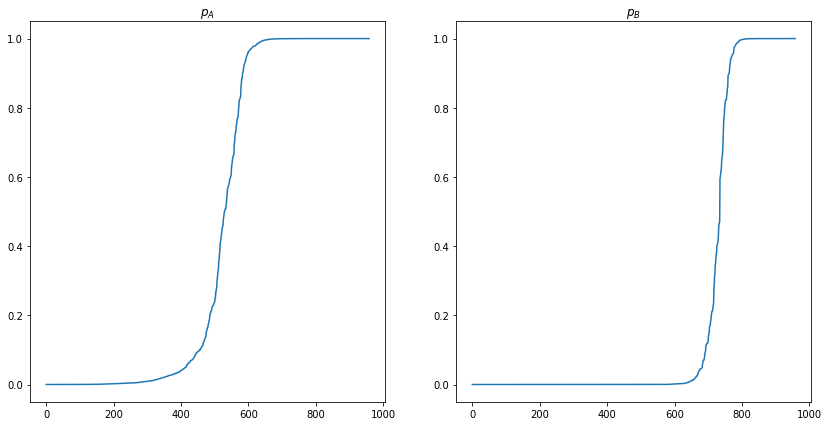

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$p_A$')
ax1.plot(sorted(proba_a[:, 1]))
ax2.set_title('$p_B$')
ax2.plot(sorted(proba_b[:, 1]));

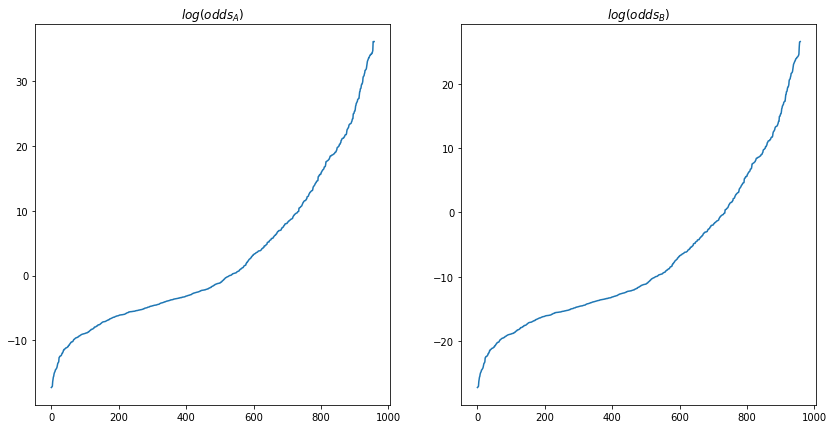

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7*2, 7))
ax1.set_title('$log(odds_A)$')
ax1.plot(sorted(log_odds_a))
ax2.set_title('$log(odds_B)$')
ax2.plot(sorted(log_odds_b));

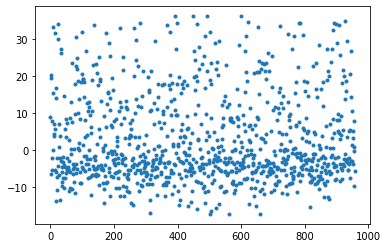

In [12]:
plt.scatter(indices, log_odds_a, marker='.');

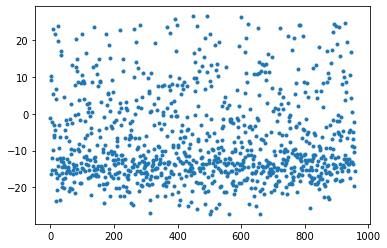

In [13]:
plt.scatter(indices, log_odds_b, marker='.');